# 3rd assignment of CS-587
## Build, Train & Test a Multilayer Neural Networks using PyTorch

You need to submit:
- This .ipynb or .py file
- A report (.pdf or .doc) with the requested tasks.
- The generated TensorBoard summaries

### Goals:
The aim of this assignment is to get familiar with:
- Building and training a feed forward neural network using the `PyTorch` framework.
- Using the SGD method for training to apply automatic differentiation based on PyTorch.
- Tuning the hyperparameters and modifying the structure of your NN to achieve the highest accuracy.
- Using the torch `nn` modules, optimizers, DataSets, and DataLoaders
- Using `Tensorboard` to visualize the graph and results.

### Dataset:
- Digits: 10 class handwritten digits
- It will automatically be downloaded once you run the provided code using the scikit-learn library.
- Check for info in the following websites:
- http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

### Additional Reading Material:
- [Tutorial on Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [Tutorial on Building a Neural Network with nn.Module](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [Tutorial on Optimizing Model Parameters](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)
- [How to use TensorBoard with PyTorch](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html)
- [Visualizing Models, Data, and Training with TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
- [TensorBoard Documentation for PyTorch](https://pytorch.org/docs/stable/tensorboard.html)

## Installing **TensorBoard**

Don't forget to install the `tensorboard` package, which is necessary for the assignment. To do that, you can simply run:
```bash
conda install conda-forge::tensorboard
```

Alternatively, you can use:
```bash
pip install tensorboard
```

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from digits import DigitsDataset
from torch.utils.data import DataLoader

from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import time

### Let's first load and visualize our dataset

========== Train Set ==========
Number of samples: 1500
X: torch.Size([1500, 64])  |  y: torch.Size([1500])


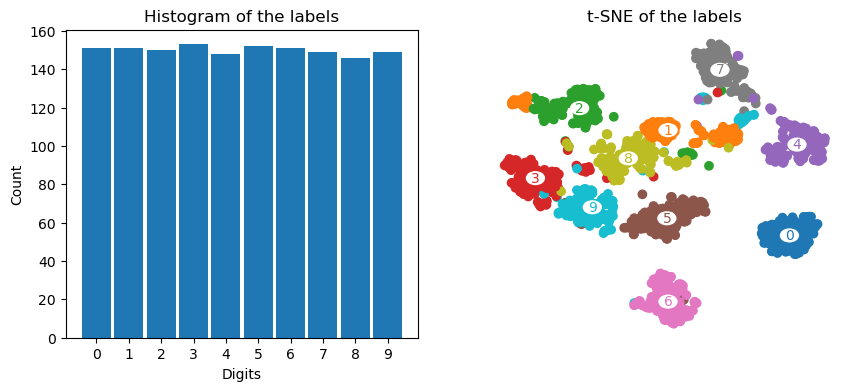

========== Test Set ==========
Number of samples: 297
X: torch.Size([297, 64])  |  y: torch.Size([297])


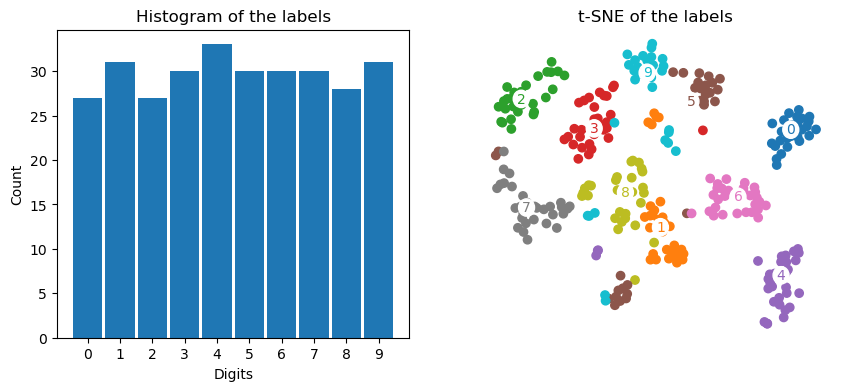

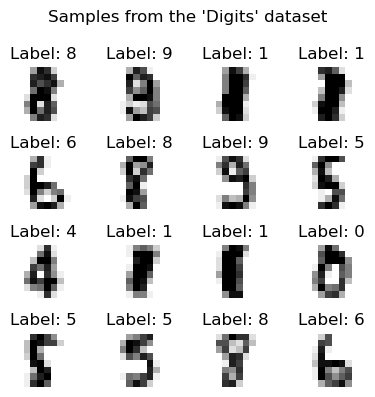

In [3]:
train_set = DigitsDataset(train=True)
test_set = DigitsDataset(train=False)

print("="*10 + " Train Set " + "="*10)
train_set.show_statistics()
print("="*10 + " Test Set " + "="*10)
test_set.show_statistics()

train_set.plot_grid(4, 4)

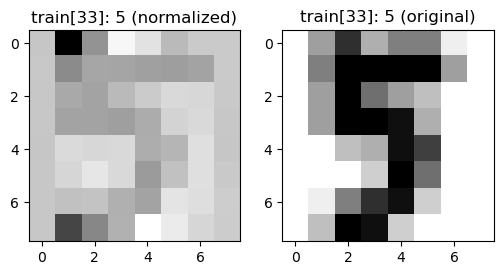

In [4]:
# how can we access a sample from the dataset, given an index?
sample_index = 33

# we can access the sample using the __getitem__ method
# which returns the x, y pair for the given index
# but, the x is normalized in our case
img1, lbl1 = train_set[sample_index]
# we can get the unnormalized version of the sample
# using the unnormalized_sample method (only in our case)
img2, lbl2 = train_set.unnormalized_sample(sample_index)


plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
img1 = img1.reshape(8, 8)
plt.imshow(img1, cmap=plt.cm.gray_r, interpolation='nearest')
plt.title(f"train[{sample_index}]: {lbl1} (normalized)")
plt.subplot(1, 2, 2)
img2 = img2.reshape(8, 8)
plt.imshow(img2, cmap=plt.cm.gray_r, interpolation='nearest')
plt.title(f"train[{sample_index}]: {lbl1} (original)")
plt.show()

## 1) Build a model using PyTorch

- Using PyTorch, build a simple model (one hidden layer)

In [4]:
def init_weights(shape: tuple):
    # initialize the weights of our model with xavier normal distribution
    return nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(shape)))

def evaluate(dataloader, model):
    # find the accuracy of the model on the given dataloader
    size = len(dataloader.dataset)
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    accuracy /= size
    return accuracy

In [5]:
# TIME TO BUILD YOUR MODEL, LOSS, AND OPTIMIZER

# hyperparameters
input_size = 64
hid_size = 15
output_size = 10
batch_size = 32
learning_rate = 0.01
num_epochs = 10

class Digits2Layer(nn.Module):
    def __init__(self, input_size, hid_size, output_size=10):
        super(Digits2Layer, self).__init__()
        ############################################
        # TODO: define the parameters of the model #
        ############################################
        self.W_h = init_weights((input_size, hid_size))
        self.b_h = nn.Parameter(torch.zeros(hid_size))
        self.W_o = init_weights((hid_size, output_size))
        self.b_o = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        #################################################
        # TODO: implement the forward pass of the model #
        # you can use 'torch.sigmoid'                   #
        #################################################
        h = torch.matmul(x, self.W_h) + self.b_h            # hidden layer
        h_act = torch.sigmoid(h)                            # hidden layer activation
        out = torch.matmul(h_act, self.W_o) + self.b_o      # output layer
        return out

model = Digits2Layer(input_size, hid_size, output_size)

#########################################################
# TODO: define the loss using torch.nn.CrossEntropyLoss #
#  with correct parameters -> check the documentation   #
#########################################################
loss_func = torch.nn.CrossEntropyLoss()

##################################################################
# TODO: set the optimizer to be SGD with the given learning rate #
##################################################################
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 2) Train your model using SGD algorithm and check the generalization on the test set of your dataset.

In [6]:
# Time to train and evaluate your model
# NOTE: You can launch tensorboard by running the following command:
#       tensorboard --logdir=runs

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# use these lists to keep track of the training loss across iterations
# and train/test accuracy across epochs
losses = []
accs_train = []
accs_test = []

# use tensorboard for visualization
writer = SummaryWriter('runs')
########################################
# TODO: use ΤensorΒoard to visualize   #
# the computational graph of the model #
########################################
inputs, classes = next(iter(train_loader))
writer.add_graph(model, inputs)


for e in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        y_pred = model(x)
        ##########################
        # TODO: compute the loss #
        ##########################
        loss = loss_func(y_pred, y)
        losses.append(loss.item())

        loss.backward()
        ###############################################
        # TODO: update the weights with the optimizer #
        ###############################################
        optimizer.step()
        optimizer.zero_grad()

        ##########################################################
        # TODO: use TensorBoard to visualize for each iteration: #
        #        - the training loss                             #
        #        - the histogram of the weights W_h              #
        ##########################################################
        writer.add_scalar('training loss', loss.item(), e * len(train_loader) + i)
        writer.add_histogram('weights W_h', model.W_h, e * len(train_loader) + i)

    ####################################################################
    # TODO: for each epoch, compute the accuracy on train and test set #
    ####################################################################
    acc_train = evaluate(train_loader, model)
    acc_test = evaluate(test_loader, model)
    accs_train.append(acc_train)
    accs_test.append(acc_test)
    ##############################################################
    # TODO: use TensorBoard to visualize for each epoch the      #
    # accuracy on the train and the test set (use the same plot) #
    ##############################################################
    writer.add_scalars('accuracy', {'train': acc_train, 'test': acc_test}, e)

    print(f"Epoch {e+1}/{num_epochs}, train accuracy: {acc_train:.3f} test accuracy: {acc_test:.3f}")

writer.close()

Epoch 1/10, train accuracy: 0.147 test accuracy: 0.162
Epoch 2/10, train accuracy: 0.187 test accuracy: 0.192
Epoch 3/10, train accuracy: 0.223 test accuracy: 0.205
Epoch 4/10, train accuracy: 0.269 test accuracy: 0.239
Epoch 5/10, train accuracy: 0.335 test accuracy: 0.290
Epoch 6/10, train accuracy: 0.399 test accuracy: 0.343
Epoch 7/10, train accuracy: 0.453 test accuracy: 0.401
Epoch 8/10, train accuracy: 0.508 test accuracy: 0.478
Epoch 9/10, train accuracy: 0.557 test accuracy: 0.512
Epoch 10/10, train accuracy: 0.600 test accuracy: 0.556


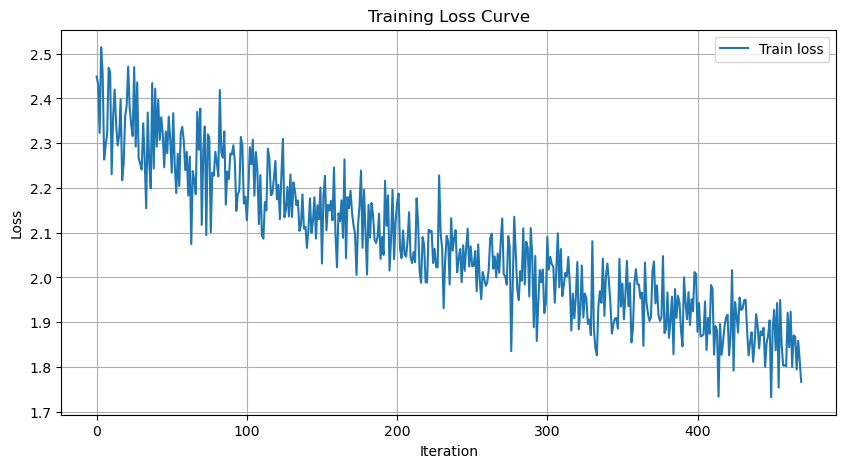

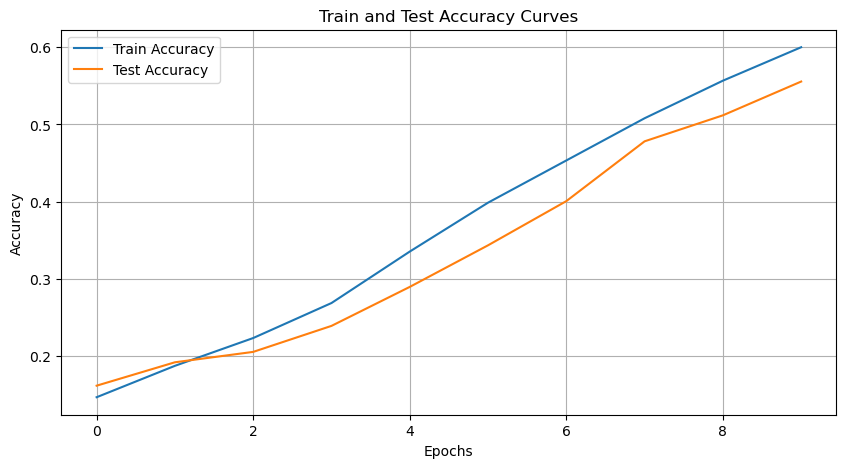

In [7]:
#########################################################################
# TODO: Plot two figures, using 'losses', 'accs_train', and 'accs_test' #
# 1. Plot the train loss curve                                          #
# 2. Plot the train and test accuracy curves in the same figure         #
# Compare the results with the ones you get from TensorBoard            #
#########################################################################
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Train loss')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accs_train, label='Train Accuracy')
plt.plot(accs_test, label='Test Accuracy')
plt.title('Train and Test Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 3) Try different settings for your model to maximize the accuracy

Play around with the structure of your NN model and fine-tune its hyperparameters.

- A. Experiment with different hyperparameters. For example, you can try:
    - learning rate $= 0.001,\dots,0.1$
    - batch size $= 8,\dots,128$
    - size of hidden layers $= 5,\dots,25$
    - different number of epochs
- B. Try different activation functions (e.g., `ReLU`, `TanH`).
- C. Try to add more hidden layers and/or increase their size.
- D. Add L2 regularization (e.g., with regularization strength $10^{-4}$)

### **Bonus:** Extra points (up to $+ 15\%$) will be distributed to the top-performing models based on the accuracy on the test set.

In [6]:
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [32]:
def grid_search(model_class, param_grid, train_set, test_set, loss_func):
    best_accuracy = 0.0
    best_params = {}

    for params in param_grid:
        train_loader = DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
        test_loader = DataLoader(test_set, batch_size=params['batch_size'], shuffle=False)

        model_params = {k: v for k, v in params.items() if k not in ['lr', 'num_epochs', 'batch_size']}
        model = model_class(**model_params)
        optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'])

        for epoch in range(params['num_epochs']):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()

        train_accuracy = evaluate_model(model, train_loader)
        test_accuracy = evaluate_model(model, test_loader)

        print(f"Num Epochs: {params['num_epochs']} LR: {params['lr']}, Batch size: {params['batch_size']}, Hidden sizes: ({model_params['hid_size1']}, {model_params['hid_size2']}), "
            f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_params = {
                'learning_rate': params['lr'],
                'batch_size': params['batch_size'],
                'hidden_sizes': (model_params['hid_size1'], model_params['hid_size2']),
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy
            }

    return best_params

In [14]:
##########################################################
# TODO: MAXimize the accuracy on the given dataset       #
# by trying different settings for your model            #
# (you only need to provide the code for one model)      #
##########################################################
class EnhancedDigitsModel(nn.Module):
    def __init__(self, input_size, hid_size1, hid_size2, output_size):
        super(EnhancedDigitsModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hid_size1)
        self.layer2 = nn.Linear(hid_size1, hid_size2)
        self.output_layer = nn.Linear(hid_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [ ]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
param_grid = [
    {'lr': lr, 'batch_size': batch_size, 'hid_size1': hid_size1, 'hid_size2': hid_size2, 'num_epochs': num_epochs, 'input_size': input_size, 'output_size': output_size}
    for lr in [0.001, 0.01, 0.1]
    for batch_size in [32, 64, 128]
    for hid_size1, hid_size2 in [(10, 5), (20, 10), (25, 15)]
    for num_epochs in [10, 50, 150]
]

best_params= grid_search(EnhancedDigitsModel, param_grid, train_set, test_set, nn.CrossEntropyLoss())

print(f"Best Model Parameters: {best_params}")
print(f"Train Accuracy: {best_params['train_accuracy']:.4f}, Test Accuracy: {best_params['test_accuracy']:.4f}")

In [16]:
# Hyperparameters
input_size = 64
output_size = 10
num_epochs = 10

# Grid of hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
hidden_sizes = [(10, 5), (20, 10), (25, 15)]

# Initialize tracking for the best model
best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hid_size1, hid_size2 in hidden_sizes:
            train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

            model = EnhancedDigitsModel(input_size, hid_size1, hid_size2, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            loss_func = nn.CrossEntropyLoss()

            for epoch in range(num_epochs):
                model.train()
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    loss.backward()
                    optimizer.step()

            train_accuracy = evaluate_model(model, train_loader)
            test_accuracy = evaluate_model(model, test_loader)

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'hidden_sizes': (hid_size1, hid_size2),
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy
                }

            print(f"LR: {lr}, Batch size: {batch_size}, Hidden sizes: ({hid_size1}, {hid_size2}), "
                f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

print(f"Best Model Parameters: {best_params}")
print(f"Best Test Accuracy: {best_params['test_accuracy']:.4f}")


LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1027, Test Acc: 0.1010
LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.1340, Test Acc: 0.1178
LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.1347, Test Acc: 0.1279
LR: 0.001, Batch size: 64, Hidden sizes: (10, 5), Train Acc: 0.0993, Test Acc: 0.1010
LR: 0.001, Batch size: 64, Hidden sizes: (20, 10), Train Acc: 0.0833, Test Acc: 0.0909
LR: 0.001, Batch size: 64, Hidden sizes: (25, 15), Train Acc: 0.1127, Test Acc: 0.1077
LR: 0.001, Batch size: 128, Hidden sizes: (10, 5), Train Acc: 0.1407, Test Acc: 0.1515
LR: 0.001, Batch size: 128, Hidden sizes: (20, 10), Train Acc: 0.1087, Test Acc: 0.1448
LR: 0.001, Batch size: 128, Hidden sizes: (25, 15), Train Acc: 0.0480, Test Acc: 0.0741
LR: 0.01, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.3313, Test Acc: 0.3064
LR: 0.01, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.5187, Test Acc: 0.4848
LR: 0.01, Batch size: 32, Hidden sizes: (25, 1

In [15]:
class ConfigurableDigitsModel(nn.Module):
    def __init__(self, input_size, hid_size1, hid_size2, output_size):
        super(ConfigurableDigitsModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hid_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hid_size1, hid_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hid_size2, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.log_softmax(self.layer3(x))
        return x

In [16]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
param_grid = [
    {'lr': lr, 'batch_size': batch_size, 'hid_size1': hid_size1, 'hid_size2': hid_size2, 'num_epochs': num_epochs, 'input_size': input_size, 'output_size': output_size}
    for lr in [0.001, 0.01, 0.1]
    for batch_size in [32, 64, 128]
    for hid_size1, hid_size2 in [(10, 5), (20, 10), (25, 15)]
    for num_epochs in [10, 50, 150]
]

best_params= grid_search(ConfigurableDigitsModel, param_grid, train_set, test_set, nn.CrossEntropyLoss())

print(f"Best Model Parameters: {best_params}")
print(f"Train Accuracy: {best_params['train_accuracy']:.4f}, Test Accuracy: {best_params['test_accuracy']:.4f}")

Epoch: 10 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1327, Test Acc: 0.1111
Epoch: 50 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1987, Test Acc: 0.1785
Epoch: 150 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.2380, Test Acc: 0.2593
Epoch: 10 LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.1020, Test Acc: 0.0976
Epoch: 50 LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.2473, Test Acc: 0.2088
Epoch: 150 LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.4240, Test Acc: 0.3906
Epoch: 10 LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.1587, Test Acc: 0.1246
Epoch: 50 LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.2287, Test Acc: 0.1953
Epoch: 150 LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.5233, Test Acc: 0.4949
Epoch: 10 LR: 0.001, Batch size: 64, Hidden sizes: (10, 5), Train Acc: 0.1067, Test Acc: 0.1044
Epoch: 50 LR: 0.001, Batch size

In [17]:
class MLPwithBatchRELUDropout(nn.Module):
    def __init__(self, input_size, hid_size1, hid_size2, output_size, dropout_rate=0.5):
        super(MLPwithBatchRELUDropout, self).__init__()
        self.layer1 = nn.Linear(input_size, hid_size1)
        self.batch_norm1 = nn.BatchNorm1d(hid_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hid_size1, hid_size2)
        self.batch_norm2 = nn.BatchNorm1d(hid_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.output_layer = nn.Linear(hid_size2, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.layer1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.layer2(x))))
        x = self.output_layer(x)
        return x

In [19]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
param_grid = [
    {'lr': lr, 'batch_size': batch_size, 'hid_size1': hid_size1, 'hid_size2': hid_size2, 'num_epochs': num_epochs, 'input_size': input_size, 'output_size': output_size, 'dropout_rate': dropout_rate}
    for lr in [0.001, 0.01, 0.1]
    for batch_size in [32, 64, 128]
    for hid_size1, hid_size2 in [(10, 5), (20, 10), (25, 15)]
    for num_epochs in [10, 50, 150]
    for dropout_rate in [0.3, 0.5, 0.7]
]

best_params= grid_search(MLPwithBatchRELUDropout, param_grid, train_set, test_set, nn.CrossEntropyLoss())

print(f"Best Model Parameters: {best_params}")
print(f"Train Accuracy: {best_params['train_accuracy']:.4f}, Test Accuracy: {best_params['test_accuracy']:.4f}")

Epoch: 10 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1407, Test Acc: 0.1582
Epoch: 10 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1373, Test Acc: 0.1178
Epoch: 10 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1327, Test Acc: 0.1145
Epoch: 50 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.3653, Test Acc: 0.2862
Epoch: 50 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.3520, Test Acc: 0.3468
Epoch: 50 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1620, Test Acc: 0.1380
Epoch: 150 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.5687, Test Acc: 0.5286
Epoch: 150 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.5247, Test Acc: 0.5051
Epoch: 150 LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.4220, Test Acc: 0.3603
Epoch: 10 LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.3560, Test Acc: 0.3333
Epoch: 10 LR: 0.001, Batch size: 32,

In [21]:
class DeeperMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeeperMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
        )

    def forward(self, x):
        return self.layers(x)

In [23]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
hidden_sizes = [(10, 5), (20, 10), (25, 15)]
epochs_list = [10, 50, 150]

# Initialize tracking for the best model
best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hid_size1, hid_size2 in hidden_sizes:
            for num_epochs in epochs_list:
                train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

                model = DeeperMLP(input_size, output_size)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                loss_func = nn.CrossEntropyLoss()

                for epoch in range(num_epochs):
                    model.train()
                    for inputs, labels in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                train_accuracy = evaluate_model(model, train_loader)
                test_accuracy = evaluate_model(model, test_loader)

                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_sizes': (hid_size1, hid_size2),
                        'train_accuracy': train_accuracy,
                        'test_accuracy': test_accuracy
                    }

                print(f"Num Epochs: {num_epochs}, LR: {lr}, Batch size: {batch_size}, Hidden sizes: ({hid_size1}, {hid_size2}), "
                    f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

print(f"Best Model Parameters: {best_params}")
print(f"Best Test Accuracy: {best_params['test_accuracy']:.4f}")

Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.1167, Test Acc: 0.0438
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.2820, Test Acc: 0.2626
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.8300, Test Acc: 0.7576
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.0913, Test Acc: 0.1212
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.4720, Test Acc: 0.4108
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.8373, Test Acc: 0.7811
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.1660, Test Acc: 0.1246
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.5827, Test Acc: 0.5185
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.7213, Test Acc: 0.6498
Num Epochs: 10, LR: 0.001, Batch size: 64, Hidden sizes: (10, 5), Train A

In [24]:
class WiderMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(WiderMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
        )

    def forward(self, x):
        return self.layers(x)

In [25]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
hidden_sizes = [(10, 5), (20, 10), (25, 15)]
epochs_list = [10, 50, 150]

# Initialize tracking for the best model
best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hid_size1, hid_size2 in hidden_sizes:
            for num_epochs in epochs_list:
                train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

                model = WiderMLP(input_size, output_size)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                loss_func = nn.CrossEntropyLoss()

                for epoch in range(num_epochs):
                    model.train()
                    for inputs, labels in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                train_accuracy = evaluate_model(model, train_loader)
                test_accuracy = evaluate_model(model, test_loader)

                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_sizes': (hid_size1, hid_size2),
                        'train_accuracy': train_accuracy,
                        'test_accuracy': test_accuracy
                    }

                print(f"Num Epochs: {num_epochs}, LR: {lr}, Batch size: {batch_size}, Hidden sizes: ({hid_size1}, {hid_size2}), "
                    f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

print(f"Best Model Parameters: {best_params}")
print(f"Best Test Accuracy: {best_params['test_accuracy']:.4f}")

Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.8020, Test Acc: 0.7037
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.9347, Test Acc: 0.8586
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.9613, Test Acc: 0.8754
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.8207, Test Acc: 0.7374
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.9273, Test Acc: 0.8249
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.9660, Test Acc: 0.8788
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.8060, Test Acc: 0.7306
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.9287, Test Acc: 0.8552
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.9640, Test Acc: 0.8721
Num Epochs: 10, LR: 0.001, Batch size: 64, Hidden sizes: (10, 5), Train A

In [26]:
class MLPWithELU(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPWithELU, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ELU(),
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        return self.layers(x)

In [27]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
hidden_sizes = [(10, 5), (20, 10), (25, 15)]
epochs_list = [10, 50, 150]

# Initialize tracking for the best model
best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hid_size1, hid_size2 in hidden_sizes:
            for num_epochs in epochs_list:
                train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

                model = MLPWithELU(input_size, output_size)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                loss_func = nn.CrossEntropyLoss()

                for epoch in range(num_epochs):
                    model.train()
                    for inputs, labels in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                train_accuracy = evaluate_model(model, train_loader)
                test_accuracy = evaluate_model(model, test_loader)

                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_sizes': (hid_size1, hid_size2),
                        'train_accuracy': train_accuracy,
                        'test_accuracy': test_accuracy
                    }

                print(f"Num Epochs: {num_epochs}, LR: {lr}, Batch size: {batch_size}, Hidden sizes: ({hid_size1}, {hid_size2}), "
                    f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

print(f"Best Model Parameters: {best_params}")
print(f"Best Test Accuracy: {best_params['test_accuracy']:.4f}")

Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.6687, Test Acc: 0.6128
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.9073, Test Acc: 0.8350
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.9573, Test Acc: 0.8552
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.7387, Test Acc: 0.6229
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.8980, Test Acc: 0.8384
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.9547, Test Acc: 0.8519
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.6407, Test Acc: 0.5758
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.9040, Test Acc: 0.8316
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.9560, Test Acc: 0.8754
Num Epochs: 10, LR: 0.001, Batch size: 64, Hidden sizes: (10, 5), Train A

---
# Best Model

In [12]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPWithDropout, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        return self.layers(x)

In [37]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
hidden_sizes = [(10, 5), (20, 10), (25, 15)]
epochs_list = [10, 50, 150]

# Initialize tracking for the best model
best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hid_size1, hid_size2 in hidden_sizes:
            for num_epochs in epochs_list:
                train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

                model = MLPWithDropout(input_size, output_size)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                loss_func = nn.CrossEntropyLoss()

                for epoch in range(num_epochs):
                    model.train()
                    for inputs, labels in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                train_accuracy = evaluate_model(model, train_loader)
                test_accuracy = evaluate_model(model, test_loader)

                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_sizes': (hid_size1, hid_size2),
                        'train_accuracy': train_accuracy,
                        'test_accuracy': test_accuracy
                    }

                print(f"Num Epochs: {num_epochs}, LR: {lr}, Batch size: {batch_size}, Hidden sizes: ({hid_size1}, {hid_size2}), "
                        f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

print(f"Best Model Parameters: {best_params}")
print(f"Best Test Accuracy: {best_params['test_accuracy']:.4f}")

Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.3833, Test Acc: 0.3502
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.7660, Test Acc: 0.6768
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.9013, Test Acc: 0.8148
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.3700, Test Acc: 0.3939
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.7547, Test Acc: 0.6330
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.9107, Test Acc: 0.8215
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.2373, Test Acc: 0.2256
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.7520, Test Acc: 0.7306
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.9053, Test Acc: 0.8316
Num Epochs: 10, LR: 0.001, Batch size: 64, Hidden sizes: (10, 5), Train A

In [13]:
# Best hyperparameters
lr = 0.1
batch_size = 32
hid_size1, hid_size2 = 25, 15
num_epochs = 150

input_size = 64
output_size = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = MLPWithDropout(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

current_time = time.strftime("%Y%m%d-%H%M%S")
log_dir = f'logs/{current_time}_lr={lr}_batch_size={batch_size}_hidden_sizes={hid_size1}_{hid_size2}_epochs={num_epochs}'
writer = SummaryWriter(log_dir)

inputs, _ = next(iter(train_loader))
writer.add_graph(model, inputs)

best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/train', loss.item(), epoch)
        writer.add_histogram('Weights/FirstLayer', model.layers[0].weight, epoch)
        writer.add_histogram('Weights/SecondLayer', model.layers[3].weight, epoch)
        writer.add_histogram('Weights/ThirdLayer', model.layers[6].weight, epoch)

    train_accuracy = evaluate_model(model, train_loader)
    test_accuracy = evaluate_model(model, test_loader)

    # Update the best accuracy
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    writer.add_scalars('Accuracy', {'train': train_accuracy, 'test': test_accuracy}, epoch)

    print(f"Epoch {epoch+1}/{num_epochs}, train accuracy: {train_accuracy:.3f}, test accuracy: {test_accuracy:.3f}")

writer.close()

print(f"Best accuracy: {best_accuracy:.3f}")

Epoch 1/150, train accuracy: 0.863, test accuracy: 0.768
Epoch 2/150, train accuracy: 0.921, test accuracy: 0.855
Epoch 3/150, train accuracy: 0.959, test accuracy: 0.882
Epoch 4/150, train accuracy: 0.967, test accuracy: 0.879
Epoch 5/150, train accuracy: 0.977, test accuracy: 0.889
Epoch 6/150, train accuracy: 0.983, test accuracy: 0.892
Epoch 7/150, train accuracy: 0.990, test accuracy: 0.896
Epoch 8/150, train accuracy: 0.992, test accuracy: 0.896
Epoch 9/150, train accuracy: 0.992, test accuracy: 0.906
Epoch 10/150, train accuracy: 0.995, test accuracy: 0.906
Epoch 11/150, train accuracy: 0.997, test accuracy: 0.909
Epoch 12/150, train accuracy: 0.996, test accuracy: 0.916
Epoch 13/150, train accuracy: 0.997, test accuracy: 0.909
Epoch 14/150, train accuracy: 0.997, test accuracy: 0.936
Epoch 15/150, train accuracy: 0.998, test accuracy: 0.929
Epoch 16/150, train accuracy: 0.997, test accuracy: 0.929
Epoch 17/150, train accuracy: 0.999, test accuracy: 0.923
Epoch 18/150, train acc

---

In [30]:
class MLPWithBatchNorm(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPWithBatchNorm, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        return self.layers(x)

In [31]:
# Hyperparameters
input_size = 64
output_size = 10

# Grid of hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
hidden_sizes = [(10, 5), (20, 10), (25, 15)]
epochs_list = [10, 50, 150]

best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hid_size1, hid_size2 in hidden_sizes:
            for num_epochs in epochs_list:
                train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

                model = MLPWithBatchNorm(input_size, output_size)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                loss_func = nn.CrossEntropyLoss()

                for epoch in range(num_epochs):
                    model.train()
                    for inputs, labels in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                train_accuracy = evaluate_model(model, train_loader)
                test_accuracy = evaluate_model(model, test_loader)

                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_sizes': (hid_size1, hid_size2),
                        'train_accuracy': train_accuracy,
                        'test_accuracy': test_accuracy
                    }

                print(f"Num Epochs: {num_epochs}, LR: {lr}, Batch size: {batch_size}, Hidden sizes: ({hid_size1}, {hid_size2}), "
                    f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

print(f"Best Model Parameters: {best_params}")
print(f"Best Test Accuracy: {best_params['test_accuracy']:.4f}")

Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.7687, Test Acc: 0.6936
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.9360, Test Acc: 0.8620
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (10, 5), Train Acc: 0.9707, Test Acc: 0.8687
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.7033, Test Acc: 0.6431
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.9387, Test Acc: 0.8316
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (20, 10), Train Acc: 0.9713, Test Acc: 0.8687
Num Epochs: 10, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.6887, Test Acc: 0.6902
Num Epochs: 50, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.9307, Test Acc: 0.8081
Num Epochs: 150, LR: 0.001, Batch size: 32, Hidden sizes: (25, 15), Train Acc: 0.9760, Test Acc: 0.8990
Num Epochs: 10, LR: 0.001, Batch size: 64, Hidden sizes: (10, 5), Train A